# Projet Photos - Création des statistiques

Récupération des données de la base mongodb

- Mise sous dataframe

- Statistiques

- Visualisations


## Avancement

### Réalisé

- affichage données début

- récupération des données mongodb dans un dataframe (par découpage possible)

- Calcul et présentation des statistiques 

    - Par nombre de fichiers + et par volume (cumul des tailles) par : 
    
        .année
        
        .mois
        
        .jour
        
        .catégorie de fichier (image, vidéo)
        
        .type de fichier
        
        .répertoire initial


### A venir

    Ajout de la prise en compte des doublons dans le calcul des statistiques.     
        
    NB : il faut pouvoir croiser les résultats
    -> utiliser Bokeh ? pour les graphes ?
    
    Gérer les dates non renseignées (il y en a)
    
        
        
### A corriger

    . Graphique par dossier : indiquer uniquement les dossiers 'volumineux' (à définir)
        
    . Date : 
        - récupérer la donnée exif 36867 pour avoir la date de prise de vue (notamment des jpg : elle peut
    être différente de st_mtime si le fichier a été modifié sur l'iphone par exemple)
        
        - pour les videos (.MOV), date st_mtime ok (pas d'autre)
   
        - pour les .PNG, st_mtime ok (pas d'autres) - rmq : correspondent à des screenshot sur iphone
        
        
    

# Imports

In [9]:
import os
import datetime as dt
from datetime import datetime
import pandas as pd

#Pour mongodb
import pymongo
from pymongo import MongoClient
from pandas import json_normalize

from matplotlib import pyplot as plt

import time





# Fonctions

### A mettre en module ?

In [2]:
#Fonction de calcul du nombre et de la taille totale des fichiers catalgués dans la base

# ! CETTE FONCTION EST UNE COPIE DE CELLE PRESENTE DANS CATALOGUE -

def fnph_clc_nb_st_size_tot(parm_collection):
    """
    Fonction de calcul du nombre et de la taille totale des fichiers catalgués dans la base
    retourne une liste de deux éléments : taille, nombre
    """
    #Requête aggrégation
    totalSize = parm_collection.aggregate(
       [
         {
           "$group":
             {
               "_id"        : "",
               "totalSize"  : { "$sum": "$stats.st_size" },
               "count"      : { "$sum": 1 }
             }
         }
       ]
    )

    
    reslist=list(totalSize)[0]
    result=[reslist['totalSize'], reslist['count']]
    return(result)

### Nouvelles fonctions

In [3]:
#import pandas as pd
#from pymongo import MongoClient

def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

In [4]:
def fnph_read_mongodb(
           parm_db_name, 
           parm_collection, 
           parm_query_match     ={},
           parm_query_projection={},
           parm_host            ='localhost', 
           parm_port            =27017, 
           parm_username        =None, 
           parm_password        =None,
           parm_chunksize       =100, 
           parm_no_id           =True,
           parm_json_normalized =True):
    """ Read from Mongo and Store into DataFrame 
    découpage en chunk - chunksize à définir, pour l'instant fixée en début de traitement
    En sortie : les données récupérées en format json ou non (parm_json_normalized)
    """

    #df_result                 = pd.DataFrame()  non ! car test sur local()
    #df_result_aux             = pd.DataFrame()
    
    # Connect to MongoDB
    db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db=parm_db_name)
    client = MongoClient(host=parm_host, port=parm_port)
    db_aux = client[parm_db_name]

    # Variables to create the chunks
    nb_enr_tot = db_aux[parm_collection].find(parm_query_match, parm_query_projection).count()
    skips_variable = range(0, nb_enr_tot, int(parm_chunksize))
    
    if len(skips_variable)<=1: #en fait il ne peut être qu'égal à 1 au minimum ou à 0 si la base est vide
        skips_variable = [0,nb_enr_tot]

    # Iteration to create the dataframe in chunks
    for i in range(1,len(skips_variable)):
        
        # Expand the cursor and construct the DataFrame                                   # <--Requête2
        # création du curseur (NB!!! le cursor est détruit dès la première utilisation - quelle qu'elle soit)
        cursor_result = db_aux[parm_collection].find(parm_query_match, parm_query_projection)[skips_variable[i-1]:skips_variable[i]]
        if parm_json_normalized:
            df_result_aux = json_normalize(cursor_result)
        else:
            df_result_aux = pd.DataFrame(list(cursor_result))

        if parm_no_id: #selon que l'on souhaite récupérer l'_id ou non (paramètrage de l'appel à la fonction)
            del df_result_aux['_id']

        # Concatenate the chunks into a unique df
        if 'df_result' not in locals():
            df_result = df_result_aux
        else:
            df_result = pd.concat([df_result, df_result_aux]            , ignore_index=True)
          
    # Récupération des derniers enregistrements (après le dernier chunk traité)    
    enr_deb = (len(skips_variable)-1)*parm_chunksize
    if nb_enr_tot - enr_deb > 0 : #Si chunksize est > au nb total d'enregs, il n'y a plus d'enregs à traiter et 
                                  #      enr_deb > nb_enr_tot, il ne reste donc plus d'enregistrements à traiter.
        enr_fin = nb_enr_tot
        print("debug-->(enr_deb,enr_fin):",(enr_deb,enr_fin))

        #                                                                                     # <--Requête3
        cursor_result = db_aux[parm_collection].find(parm_query_match, parm_query_projection)[enr_deb:enr_fin]
        df_result_aux =pd.DataFrame(list(cursor_result)) #<--Requête3

        if 'df_result' not in locals():
            df_result             = df_result_aux
        else:
            df_result             = pd.concat([df_result, df_result_aux], ignore_index=True)
    else:
        print("(warning) chunksize supérieur au nombre d''enregistrements récupérés.")

    print('debug-->nb_enr_tot=', nb_enr_tot)
    return df_result


In [5]:
%%time
#Test fnph_read_mongodb()


import datetime
from datetime import datetime

#client = pymongo.MongoClient('localhost',27017)
#mydb = client["prjph_catalogue"]
test1mydb_name = "prjph_catalogue"
test1mycollection_name = "test_documents"          #TEST
#mycollection_name = "images_videos"           #PREPROD
#------ ---------- -------------------*
#mycollection = mydb[mycollection_name]


test1mysize  = 1000

test1myquery_match      =  {"extfile":".mov"} #le null ne convient pas à Python
#test1myquery_match      =  {} #le null ne convient pas à Python
#   projection-->
test1myquery_projection =  {    "_id"              :1,
                                "filename"         :1, 
                                "exif.36865"       :1, 
                                "exif.36866"       :1, 
                                "stats.st_mtime"   :1, 
                                "stats.st_size"    :1, 
                                "orgnl_dirname"    :1, 
                                "doctype"          :1, 
                                "extfile"          :1, 
                                "vid_ppty.duration":1, 
                                "exif.271"         :1, 
                                "exif.272"         :1  
                           }
#testmyquery_match={}
#testmyquery_projection={}

#Traitement
mydate=datetime.now()
mychunksize=test1mysize
start=datetime.now()
df_test1    = pd.DataFrame()
df_test1    = fnph_read_mongodb(test1mydb_name, 
                             test1mycollection_name, 
                             parm_query_match       = test1myquery_match, 
                             parm_query_projection  = test1myquery_projection,
                             parm_chunksize=test1mysize, 
                             parm_no_id=False,
                             parm_json_normalized = True)
end  = datetime.now()
timelaps=end-start
print('durée :', timelaps)
print('df_test1.shape =', df_test1.shape)


(warning) chunksize supérieur au nombre d''enregistrements récupérés.
debug-->nb_enr_tot= 6
durée : 0:00:00.036979
df_test1.shape = (5, 8)
Wall time: 38 ms


<ipython-input-4-ec110930055b>:27: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  nb_enr_tot = db_aux[parm_collection].find(parm_query_match, parm_query_projection).count()


In [6]:
df_test1.head(2)


,_id,doctype,orgnl_dirname,filename,extfile,stats.st_mtime,stats.st_size,vid_ppty.duration
0,5f922be0050b585522ee3f49,video,[C:\Users\LENOVO\Documents\Projets\Prj_photos\...,IMG_0578.MOV,.mov,1.503662e+09,27090151,12
1,5f922be0050b585522ee3f4a,video,[C:\Users\LENOVO\Documents\Projets\Prj_photos\...,IMG_0649.MOV,.mov,1.503916e+09,28207499,14


# Traitement principal


           global_unique_id: 1603490694.852586 

start..................... :  2020-10-24 00:04:54.854582 


**** Collection            : images_videos ****

****
****
****
****
****


<ipython-input-4-ec110930055b>:27: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  nb_enr_tot = db_aux[parm_collection].find(parm_query_match, parm_query_projection).count()


debug-->(enr_deb,enr_fin): (155000, 158254)
debug-->nb_enr_tot= 158254

done----------------------------------------
df_stats.shape=(158222, 18)
Durée du traitement               : 0:00:27.602161
done----------------------------------------
prjph_df_log_stats__1603490694_852586__images_videos__.csv saved into C:\Users\LENOVO\Documents\Projets\Prj_photos\Prjph_log

ended..................... :  2020-10-24 00:05:22.456743 

Wall time: 27.8 s


<Figure size 1080x360 with 0 Axes>

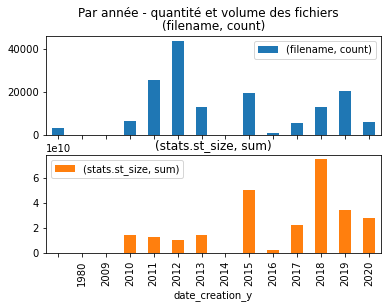

<Figure size 1080x360 with 0 Axes>

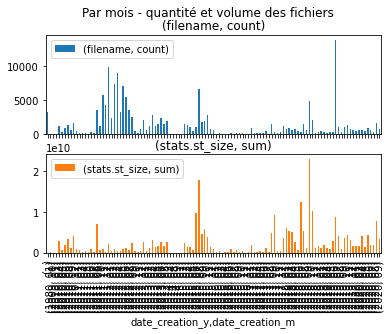

<Figure size 1080x360 with 0 Axes>

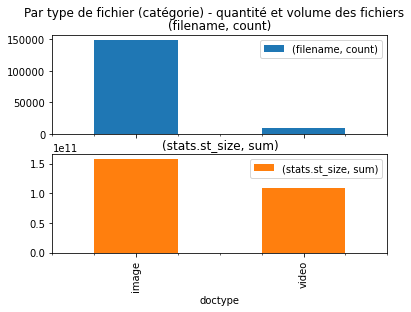

<Figure size 1080x360 with 0 Axes>

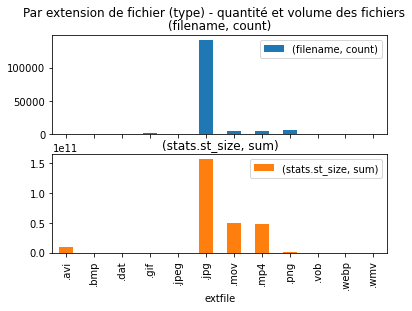

<Figure size 1080x360 with 0 Axes>

C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128062 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127804 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 129346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127874 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127873 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128150 mi

C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128131 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 127876 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 127880 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 127870 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LENOVO\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128147 missing from current font.
  font.set_text(s, 0, flags=flags)


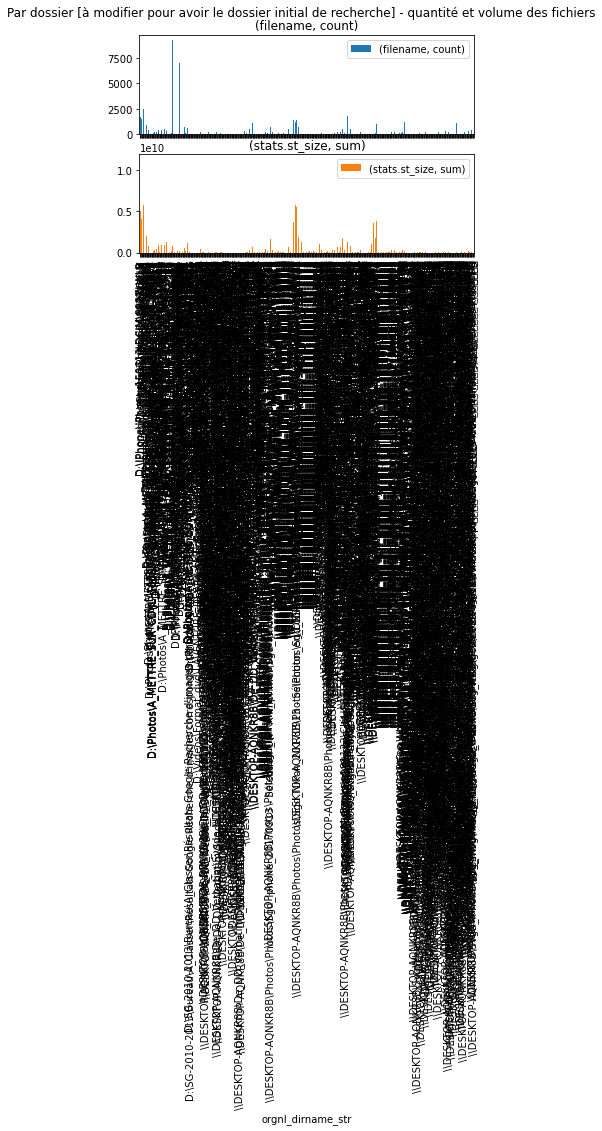

<Figure size 1080x360 with 0 Axes>

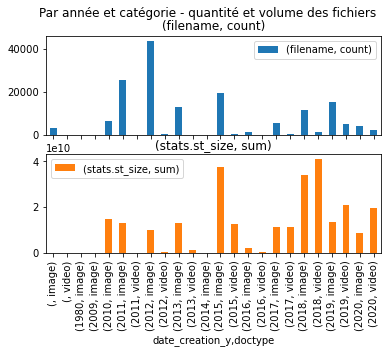

In [15]:
%%time
#Programme principal

#----------------------------------------------------------------------------------------------------------
#description :

# Préparation
# - Accès à la bd mongdodb
# - Récupération des données dans un df (par découpage pour gérer vitesse vs utilisation mémoire)

# Obtention des statistiques

# Présentation des statistiques
#----------------------------------------------------------------------------------------------------------


#Paramètres utilisateurs***********************************************************************************
#Libellé traitement 1<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
montitre_traitement="Stats - Premier traitement"
#Répertoire de sauvegarde de l'historique du traitement
parm_df_log_rep = r'C:\Users\LENOVO\Documents\Projets\Prj_photos\Prjph_log'
#Paramètres de connexion
#------ Base  -------------------*
#connection au serveur mongodb 27017, base test
client = pymongo.MongoClient('localhost',27017)
mydb = client["prjph_catalogue"]
mydb_name = "prjph_catalogue"
mychunksize = 5000                #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#Collection                        2<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#mycollection_name = "test_documents"          #TEST
mycollection_name = "images_videos"           #PREPROD
#------ ---------- -------------------*
mycollection = mydb[mycollection_name]
#Paramètres utilisateurs***********************************************************************************

#----------------
#DEBUT TRAITEMENT
#----------------

#----------------
#initialisations
#----------------

#Compteurs

#init du df historique des répertoires traités
df_log=pd.DataFrame(columns=['unique_id','time','rep_explored','nb_sous_rep', 'nb_of_files', 'nb_of_files_cumul', 'comment'])          #df contenant la liste des répertoires traités

#init du df historique des répertoires traités
df_stats=pd.DataFrame()          #NB : les colonnes du df seront définies par l'appel à fnph_read_mongodb

#global_unique_id : Variable de valeur unique pour rsgner unique_id lors des différents appels
strtimestamp = str(datetime.timestamp(datetime.now()))
global_unique_id = strtimestamp
print('\n           global_unique_id:', global_unique_id,'\n')

#------------
# TRAITEMENT
#------------

#==========*Entête*============
start_time=datetime.now()
print('start..................... : ', start_time, '\n')

print("\n**** Collection            :", mycollection_name, "****\n")
print("****")
print("****")
print("****")
print("****")
print("****")

#==========*Récupération des données*============

#----Volume de la base : 
vol_base = fnph_clc_nb_st_size_tot(mycollection)

#----Stockage en dataframe des données utiles

#"filename"         :1, #nom du fichier
#"exif.36865"       :1, #exif date de création 
#"exif.36866"       :1, #exif date de mise en data par l'appareil (~date de création?)
#"stats.st_mtime"   :1, #date de dernière modification (~date de création)
#"stats.st_size"    :1, #taille en octets   
#"orgnl_dirname"    :1, #nom du répertoire de stockage (au moment de la création du catalogue)
#"doctype"          :1, #catégorie de fichier
#"extfile"          :1, #extension du fichier (type)
#"vid_ppty.duration":1, #durée (si vidéo)
#"exif.271"         :1, #nom du fabriquant
#"exif.272"         :1  #nom du modèle

#myquery = { [ QueryMatch, QueryProject ] }

#   match--> tous les documents (hors eventsgnls)
#myquery_match      =  {"eventgnls":{"$eq":null} } }, #le null ne convient pas à Python
#myquery_match      =  {"eventgnls":""} #le null ne convient pas à Python
#myquery_match      =  {"extfile":".jpg"}
myquery_match      =  {}

#   projection-->
myquery_projection =  { "_id"              :0,
                        "filename"         :1, 
                        "stats.st_size"    :1, 
                        "stats.st_mtime"   :1, 
                        "exif.36865"       :1, 
                        "exif.36866"       :1, 
                        "extfile"          :1, 
                        "doctype"          :1, 
                        "orgnl_dirname"    :1, 
                        "vid_ppty.duration":1, 
                        "exif.271"         :1, 
                        "exif.272"         :1  
                      }

deb=datetime.now()
#print('debug-->avant read_mongodb :', deb)

#=======Requête de lecture de mongodb et récupération des données au format json normalized si souhaité================
df_stats = fnph_read_mongodb(mydb_name, 
                             mycollection_name, 
                             myquery_match, 
                             myquery_projection, 
                             parm_chunksize = mychunksize, 
                             parm_no_id = False,
                             parm_json_normalized = True)
#=======Requête de lecture de mongodb==================================================================================


#--------------------------------------------------------
# CALCUL ET REPRESENTATION GRAPHIQUE DES STATISTIQUES
#--------------------------------------------------------

#Préparation du df (df_stats) -------------
#Ajout de colonnes

#Conversion de st_mtime (timestamp) en date claire
df_stats['date_creation'    ]   = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%Y%m%d', time.localtime(x))  if pd.notnull(x) else '')
df_stats['date_creation_y'  ] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%Y'    , time.localtime(x))  if pd.notnull(x) else '')
df_stats['date_creation_m'  ] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%m'    , time.localtime(x))  if pd.notnull(x) else '')
df_stats['date_creation_d'  ] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%d'    , time.localtime(x))  if pd.notnull(x) else '')
df_stats['date_creation_hms'] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%H%M%S', time.localtime(x))  if pd.notnull(x) else '')

#Conversion de orgnl_dirname (liste) en string (la liste ne contient qu'un seul élément)
df_stats['orgnl_dirname_str'] = df_stats['orgnl_dirname'].apply(lambda x: x[0])


#--------------------
# GRAPHIQUES
#--------------------

# - Quantités et volumes

mytitle = 'Par année - quantité et volume des fichiers'
plt.figure(figsize=(15,5))
#df_sq_year = df_stats.groupby(df_stats['date_creation_y']).size()
df_sq_year = df_stats.groupby('date_creation_y').agg({'filename':['count'], 'stats.st_size':['sum']})
#df_sq_year.plot.bar()
df_sq_year.plot(kind='bar',subplots=True,sharex=True,sharey=False,title=mytitle);

mytitle = 'Par mois - quantité et volume des fichiers'
plt.figure(figsize=(15,5))
df_sq_month = df_stats.groupby(['date_creation_y','date_creation_m']).agg({'filename':['count'], 'stats.st_size':['sum']})
#df_sq_month.plot.bar()
df_sq_month.plot(kind='bar',subplots=True,sharex=True,sharey=False,title=mytitle);


mytitle = 'Par type de fichier (catégorie) - quantité et volume des fichiers'
plt.figure(figsize=(15,5))
df_sc = df_stats.groupby('doctype').agg({'filename':['count'], 'stats.st_size':['sum']})
df_sc.plot(kind='bar',subplots=True,sharex=True,sharey=False,title=mytitle);

mytitle = 'Par extension de fichier (type) - quantité et volume des fichiers'
plt.figure(figsize=(15,5))
df_st = df_stats.groupby('extfile').agg({'filename':['count'], 'stats.st_size':['sum']})
df_st.plot(kind='bar',subplots=True,sharex=True,sharey=False,title=mytitle);

mytitle = 'Par dossier [à modifier pour avoir le dossier initial de recherche] - quantité et volume des fichiers'
plt.figure(figsize=(15,5))
df_st = df_stats.groupby('orgnl_dirname_str').agg({'filename':['count'], 'stats.st_size':['sum']})
df_st.plot(kind='bar',subplots=True,sharex=True,sharey=False,title=mytitle);



# Croisements
mytitle = 'Par année et catégorie - quantité et volume des fichiers'
plt.figure(figsize=(15,5))
df_syc = df_stats.groupby(['date_creation_y','doctype']).agg({'filename':['count'], 'stats.st_size':['sum']})
df_syc.plot(kind='bar',subplots=True,sharex=True,sharey=False,title=mytitle);




# --------------------
# FIN DE TRAITEMENT
# --------------------
fin=datetime.now()
#print('debug-->après read_mongodb :', fin, "durée :", fin-deb)
    
#ajout de la ligne start dans df_log 
#rmq : nb_sous_rep et nb_of_files sont les documents à la racine du répertoire, pas le total
df_log=df_log.append({'unique_id'   :global_unique_id,
                      'time'        :str(datetime.now()),
                      'rep_explored':" <--- début de traitement - <"+montitre_traitement+">-->",
                      'comment'     :"start "}, ignore_index=True)


# ==============STATS DU TRAITEMENT===================
msg    = ['']*12
end_time=datetime.now()
msg[0] = '\ndone----------------------------------------'
msg[1] = 'df_stats.shape=' + str(df_stats.shape)
msg[2] = ''
msg[3] = ''
msg[4] = ''
#msg[5] = 'taille ttle des fichiers en base  : ' + str(var_tailletot)
#msg[6] = 'nombre ttl de  documents en base  : ' + str(var_nbtot)
msg[7] = 'Durée du traitement               : ' + str(end_time - start_time)
msg[8] = ''
msg[9] = ''
msg[10] = 'done----------------------------------------'
for i in range(len(msg)):
    if msg[i]!='':
        print(msg[i])

        
#Stockage de la fin de traitement dans l'historique df_log.
for i in range(len(msg)):
    if msg[i]!="":
        df_log=df_log.append({'unique_id'   : global_unique_id,
                              'time'        : str(end_time),
                              'comment'     : msg[i]}, ignore_index=True)

#Sauvegarde du df_log - nom complété de la collection et nom du répertoire exploré
dnow = datetime.now()
strtimestamp = str(datetime.timestamp(dnow)).replace('.','_')
mypathlog=r'C:\Users\LENOVO\Documents\Projets\Prj_photos\Prjph_log'

df_log_filename= 'prjph_df_log_stats__' +                                   \
                    global_unique_id.replace('.','_') + "__" +        \
                    mycollection_name + "__" +                        \
                 '.csv' #référencement avec global_unique_id utilisé pour référencer les documents dans la base.
df_log.to_csv(os.path.join(mypathlog,df_log_filename), sep='\t')
print(df_log_filename, 'saved into', mypathlog)

print('\nended..................... : ', end_time, '\n')

#Programme principal fin



In [14]:
df_sq_month = df_stats.groupby(['date_creation_y','date_creation_m']).agg({'filename':['count'], 'stats.st_size':['sum']})
df_sq_month.head()

filename stats.st_size
                                   count           sum
date_creation_y date_creation_m                       
                                    3254  0.000000e+00
1980            01                    62  9.055229e+07
2009            10                    17  2.231007e+07
2010            01                     1  8.801490e+05
                03                  1220  2.752882e+09

In [8]:

mytitle = 'Par mois - quantité et volume des fichiers'
plt.figure(figsize=(15,5))
df_sq_month = df_stats.groupby(['date_creation_y','date_creation_m']).agg({'filename':['count'], 'stats.st_size':['sum']})
#df_sq_month.plot.bar()
df_sq_month.plot(kind='bar',subplots=True,sharex=True,sharey=False,title=mytitle);


KeyError: 'date_creation_y'

<Figure size 1080x360 with 0 Axes>

In [ ]:
mytitle = 'Par année et catégorie - quantité et volume des fichiers'
plt.figure(figsize=(20,20))
df_syc = df_stats.groupby(['date_creation_y','doctype']).agg({'filename':['count'], 'stats.st_size':['sum']})
df_syc.plot(kind='bar',subplots=True,sharex=True,sharey=False,title=mytitle);


In [ ]:
df_stats.head(1)

In [ ]:
#plt.figure(figsize=(15,5))
#df_sd_year = df_stats[['date_creation_y','orgnl_dirname']].groupby(df_stats['date_creation_y']).sum()
#df_sd_year.plot.bar()
#df_stats.groupby('date_creation_y').agg({'doctype':['count']}).plot()
#df_sq_year = df_stats.groupby(['date_creation_y','date_creation_m']).agg({'extfile':['count']})

#df_sc_year = df_stats.groupby(['date_creation_y','doctype']).agg({'filename':['count'],'stats.st_size':['sum']})
#df_sc_year['filename','count'].plot()
#df_sc_year['filename','count']

#df_sd_year = df_stats[['date_creation_y','orgnl_dirname']].groupby(df_stats['date_creation_y']).sum()
df_test = df_stats.groupby(['date_creation_y']).agg({'filename':['count'], 'stats.st_size':['sum']})#.rename(['a','b','c'])
df_test.plot(kind='bar',subplots=True,sharex=True,sharey=False,title='Année');



In [ ]:
#for i in range(df_stats.shape[0]):
#    print(len(df_stats['orgnl_dirname'].iloc[i]))
    

mylist = [len(df_stats['orgnl_dirname'].iloc[i]) for i in range(df_stats.shape[0])]

    

In [ ]:
df_stats['orgnl_dirname_str']=df_stats['orgnl_dirname'].apply(lambda x: x[0])

In [ ]:
df_stats

In [ ]:
#essai de transformtion de format de date
df=df_stats.copy()
df.date_creation = pd.to_datetime(df['stats.st_mtime'], unit='s')
df.head()

In [ ]:
#tz_localize...ne marche pas ?
#df=df_stats.copy()
#df.date_creation = df['stats.st_mtime'].dt.tz_localize('UTC')


In [ ]:
df_stats#['filename'].sort_values()

In [ ]:
%%time
# TEST DE REFORMATAGE PAR BOUCLE AVEC ILOC - TRES LONG !
# ATTENTION : NE FONCTIONNE PAS SI LA VALEUR EST NaN or il y en a (...cf. gérer les dates non renseignées)

import time
import sys
import tqdm
#df_stats['newdate']=time.strft('%A, %Y-%m-%d %H:%M:%S', time. localtime(df_stats['stats.st_mtime'][3]))
df_stats['date_creation']=""
df_stats['date_creation_y']=""
df_stats['date_creation_m']=""
df_stats['date_creation_d']=""
df_stats['date_creation_hms'] = ""


mydate=time.strftime('%A, %Y-%m-%d %H:%M:%S', time. localtime(df_stats['stats.st_mtime'][3]))
#mydate_year=time.strftime('%Y', time. localtime(df_stats['stats.st_mtime'][3]))
#mydate_month=time.strftime('%m', time. localtime(df_stats['stats.st_mtime'][3]))
#mydate_ymd=time.strftime('%y%m%d', time. localtime(df_stats['stats.st_mtime'][3]))

#for i in tqdm.tqdm(range(df_stats.shape[0])):
#for i in range(df_stats.shape[0]):
    #df_stats['date_creation']=time.strftime('%Y%m%d', time.localtime(df_stats['stats.st_mtime']))
#    datetoconvert = time.localtime(df_stats['stats.st_mtime'].iloc[i])
#    df_stats['date_creation'].iloc[i]  = time.strftime('%Y%m%d', datetoconvert )
#    df_stats['date_creation_y'].iloc[i]= time.strftime('%y'    , datetoconvert )
#    df_stats['date_creation_m'].iloc[i]= time.strftime('%m'    , datetoconvert )
#    df_stats['date_creation_d'].iloc[i]= time.strftime('%d'    , datetoconvert )
#    
#    msg=str(i) + "-----------" + str(df_stats['date_creation'].iloc[i])
#    sys.stdout.write("\r"+msg)
#    sys.stdout.flush()

df_stats[['date_creation','date_creation_y','date_creation_m','date_creation_d']]

In [ ]:
%%time
#Conversion de st_mtime (timestamp) en date claire
df_stats['date_creation'    ] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%Y%m%d', time.localtime(x))  if pd.notnull(x) else '')
df_stats['date_creation_y'  ] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%Y'    , time.localtime(x))  if pd.notnull(x) else '')
df_stats['date_creation_m'  ] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%m'    , time.localtime(x))  if pd.notnull(x) else '')
df_stats['date_creation_d'  ] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%d'    , time.localtime(x))  if pd.notnull(x) else '')
df_stats['date_creation_hms'] = df_stats['stats.st_mtime'].apply(lambda x: time.strftime('%H%M%S', time.localtime(x))  if pd.notnull(x) else '')


In [ ]:
import numpy as np
mask=(df_stats['stats.st_mtime']).isna()==False
df_stats[mask][['stats.st_mtime','date_creation','date_creation_y','date_creation_m','date_creation_d',
               'date_creation_hms']]

# Tests

In [ ]:
%%time
#Test de fnph_read_mongodb avec graphique pour évaluer la bonne taille des 'chunks'
df_graph=pd.DataFrame(columns=['date','size','timelaps'])

#variables de test
mycollection_name="images_videos"
tot_enr = mydb[mycollection_name].find({}).count()
mysize  = 10000

#Test de fnph_read_mongodb(
myquery_match      =  {"eventgnls":""} #le null ne convient pas à Python
#   projection-->
myquery_projection =  { "_id"              :0,
                        "filename"         :1, 
                        "exif.36865"       :1, 
                        "exif.36866"       :1, 
                        "stats.st_mtime"   :1, 
                        "stats.st_size"    :1, 
                        "orgnl_dirname"    :1, 
                        "doctype"          :1, 
                        "extfile"          :1, 
                        "vid_ppty.duration":1, 
                        "exif.271"         :1, 
                        "exif.272"         :1  
                      }
myquery_match={}
myquery_projection={}

#Traitement
mydate=datetime.now()
for i_size in list(range(0,tot_enr,mysize))[1:]:
    mychunksize=i_size
    start=datetime.now()
    dftest4 = fnph_read_mongodb(mydb_name, mycollection_name, parm_query_match=myquery_match,parm_query_projection=myquery_projection,parm_chunksize=mychunksize, parm_no_id=False)
    end  = datetime.now()
    timelaps=end-start
    print(i_size, timelaps)
    df_graph = df_graph.append({ 'date':mydate, 'size':i_size, 'timelaps': timelaps}, ignore_index=True) 
    dftest4.shape
    
print('df_graph.shape=', df_graph.shape, '\ntot_enr=', tot_enr)

df_graph.iloc[:,1:].plot()

stamp = str(datetime.timestamp(mydate)).replace('.','_')

df_graph_filename= 'prjph_df_graph__' +                                   \
                    mycollection_name + "__" +                        \
                    stamp + \
                   '.csv'
df_graph_filename
df_graph.to_csv(os.path.join(mypathlog,df_graph_filename), sep='\t')


In [ ]:
dtest={ "st_atime" : 1602889146.53917,
        "st_atime_ns" : (1602889146539166100),
        "st_ctime" : 1602518764.40407,
        "st_ctime_ns" : (1602518764404068000),
        "st_dev" : 344933136,
        "st_file_attributes" : 32,
        "st_gid" : 0,
        "st_ino" : (4503599627581664),
        "st_mode" : 33206,
        "st_mtime" : 1592083818.37079,
        "st_mtime_ns" : (1592083818370789100),
        "st_nlink" : 1,
        "st_reparse_tag" : 0,
        "st_size" : 1055625,
        "st_uid" : 0 }



In [ ]:
#Test d'une partie de fnph_read_mongodb

testmydb_name = "prjph_catalogue"
testmycollection_name = "test_documents"

testmyquery_match      =  {"extfile":".jpg"} #le null ne convient pas à Python
#   projection-->
testmyquery_projection =  { "_id"              :0,
                        "filename"         :1, 
                        "exif.36865"       :1, 
                        "exif.36866"       :1, 
                        "stats.st_mtime"   :1, 
                        "stats.st_size"    :1, 
                        "orgnl_dirname"    :1, 
                        "doctype"          :1, 
                        "extfile"          :1, 
                        "vid_ppty.duration":1, 
                        "exif.271"         :1, 
                        "exif.272"         :1  
                      }

#testmyquery_match={}
#testmyquery_projection={}

# Connect to MongoDB
#db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db=mydb_name)
testclient = MongoClient(host='localhost', port=27017)
testdb_aux = testclient[testmydb_name]

testnb_enr  = testdb_aux[testmycollection_name].find(testmyquery_match, testmyquery_projection).count()

test_cursor = testdb_aux[testmycollection_name].find(testmyquery_match, testmyquery_projection)

test_df = pd.DataFrame(columns=["a","b","c","d","e","f"])
test_df = pd.DataFrame(testdb_aux[testmycollection_name].find(testmyquery_match, testmyquery_projection))
test_df_json = json_normalize(test_cursor)


print(test_df.shape)
print(test_df_json.shape)

test_df.head()
test_df_json.head()



In [ ]:
test_cursor

In [ ]:
from pandas import json_normalize

dftest2 = json_normalize(test_cursor)

In [ ]:
dftest2

In [ ]:
#Test affichage des données timestamp de la base
dtest={ "st_atime" : 1569531541.42495,
        "st_atime_ns" : (1602889146539166100),
        "st_ctime" : 1602518764.40407,
        "st_ctime_ns" : (1602518764404068000),
        "st_dev" : 344933136,
        "st_file_attributes" : 32,
        "st_gid" : 0,
        "st_ino" : (4503599627581664),
        "st_mode" : 33206,
        "st_mtime" : 1331003904.0,
        "st_mtime_ns" : (1592083818370789100),
        "st_nlink" : 1,
        "st_reparse_tag" : 0,
        "st_size" : 1055625,
        "st_uid" : 0 }



from datetime import date

#device
print(dtest["st_dev"])

#size of file in octets
print(dtest["st_size"])

#Date de création
# ---> si exif existe : 36867 (date et heure) (The date and time when the original image data was generated. 
                                #For a digital still camera the date and time the picture was taken are recorded.) ou 
#                       36868 (The date and time when the image was stored as digital data.)
# ---> Sinon :
print(date.fromtimestamp(dtest["st_mtime"])) #most recent content modification (date et heure - si secondes<>0)



##most recent content access
#print(date.fromtimestamp(dtest["st_atime"]))



from datetime import date

#device
print(dtest["st_dev"])

#size of file in octets
print(dtest["st_size"])

#Date de création
# ---> si exif existe : 36867 (date et heure) (The date and time when the original image data was generated. 
                                #For a digital still camera the date and time the picture was taken are recorded.) ou 
#                       36868 (The date and time when the image was stored as digital data.)
# ---> Sinon :
print(date.fromtimestamp(dtest["st_mtime"])) #most recent content modification (date et heure - si secondes<>0)



##most recent content access
#print(date.fromtimestamp(dtest["st_atime"]))

